# Day 7: Building a Complete MLP Trading Model

**Topics:**
- End-to-end MLP architecture for stock prediction
- Training loop with validation
- Model evaluation and metrics
- Hyperparameter tuning basics

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Libraries loaded!")
print(f"📚 Day 7: Complete MLP Trading Model")
print(f"🖥️  Device: {device}")

✅ Libraries loaded!
📚 Day 7: Complete MLP Trading Model
🖥️  Device: cpu


---

## Part 1: Data Preparation

In [2]:
# Generate realistic synthetic stock data
print("GENERATING STOCK DATA")
print("="*60)

np.random.seed(42)
n_days = 1500  # ~6 years of trading data

# Simulate price with trend and volatility clustering
returns = np.zeros(n_days)
volatility = 0.02

for i in range(1, n_days):
    # GARCH-like volatility
    volatility = 0.01 + 0.85 * volatility + 0.1 * abs(returns[i-1])
    volatility = np.clip(volatility, 0.005, 0.05)
    # Return with small drift
    returns[i] = 0.0002 + volatility * np.random.randn()

# Create price series
price = 100 * np.cumprod(1 + returns)

# Create features DataFrame
df = pd.DataFrame({'price': price, 'returns': returns})

# Technical indicators as features
df['returns_lag1'] = df['returns'].shift(1)
df['returns_lag2'] = df['returns'].shift(2)
df['returns_lag3'] = df['returns'].shift(3)
df['returns_lag5'] = df['returns'].shift(5)
df['volatility_5d'] = df['returns'].rolling(5).std()
df['volatility_20d'] = df['returns'].rolling(20).std()
df['momentum_5d'] = df['returns'].rolling(5).sum()
df['momentum_20d'] = df['returns'].rolling(20).sum()
df['ma_ratio'] = df['price'].rolling(5).mean() / df['price'].rolling(20).mean()
df['rsi'] = 50  # Simplified - would normally calculate properly

# Target: Next day direction (up=1, down=0)
df['target'] = (df['returns'].shift(-1) > 0).astype(int)

# Drop NaN
df = df.dropna().reset_index(drop=True)

print(f"Dataset size: {len(df)} days")
print(f"\nFeatures:")
feature_cols = ['returns_lag1', 'returns_lag2', 'returns_lag3', 'returns_lag5',
                'volatility_5d', 'volatility_20d', 'momentum_5d', 'momentum_20d', 'ma_ratio']
for col in feature_cols:
    print(f"  • {col}")

print(f"\nTarget distribution:")
print(f"  Up days:   {(df['target']==1).sum()} ({(df['target']==1).mean()*100:.1f}%)")
print(f"  Down days: {(df['target']==0).sum()} ({(df['target']==0).mean()*100:.1f}%)")

GENERATING STOCK DATA
Dataset size: 1481 days

Features:
  • returns_lag1
  • returns_lag2
  • returns_lag3
  • returns_lag5
  • volatility_5d
  • volatility_20d
  • momentum_5d
  • momentum_20d
  • ma_ratio

Target distribution:
  Up days:   776 (52.4%)
  Down days: 705 (47.6%)


In [3]:
# Temporal train/val/test split
print("DATA SPLIT")
print("="*60)

# 70% train, 15% val, 15% test (temporal order!)
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

print(f"Train: {len(train_df)} samples")
print(f"Val:   {len(val_df)} samples")
print(f"Test:  {len(test_df)} samples")

# Scale features (fit on train only!)
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_val = scaler.transform(val_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])

y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

# Convert to tensors
X_train_t = torch.FloatTensor(X_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)
y_val_t = torch.FloatTensor(y_val).unsqueeze(1).to(device)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(device)

# Create dataloaders
batch_size = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"\n✅ Data prepared. Shape: ({X_train.shape[0]}, {X_train.shape[1]})")

DATA SPLIT
Train: 1036 samples
Val:   222 samples
Test:  223 samples

✅ Data prepared. Shape: (1036, 9)


---

## Part 2: MLP Model Architecture

In [4]:
# Complete MLP model with best practices
print("MLP MODEL ARCHITECTURE")
print("="*60)

class TradingMLP(nn.Module):
    """
    Multi-Layer Perceptron for stock direction prediction.
    
    Architecture:
    Input → BatchNorm → (Dense → ReLU → Dropout) × N → Output
    """
    
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], dropout_rate=0.3):
        super().__init__()
        
        layers = []
        
        # Input batch normalization
        layers.append(nn.BatchNorm1d(input_dim))
        
        # Hidden layers
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())  # Binary classification
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.network(x)

# Create model
input_dim = len(feature_cols)
model = TradingMLP(
    input_dim=input_dim,
    hidden_dims=[64, 32, 16],
    dropout_rate=0.3
).to(device)

print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

MLP MODEL ARCHITECTURE
TradingMLP(
  (network): Sequential(
    (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=9, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=16, out_features=1, bias=True)
    (14): Sigmoid()
  )
)

Total parameters: 3,507
Trainable parameters: 3,507


---

## Part 3: Training Loop

In [5]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [6]:
# Training function
print("TRAINING")
print("="*60)

def train_model(model, train_loader, X_val, y_val, epochs=200, lr=0.001):
    """
    Complete training loop with validation and early stopping.
    """
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    early_stopping = EarlyStopping(patience=30)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
            predictions = (outputs > 0.5).float()
            train_correct += (predictions == y_batch).sum().item()
            train_total += y_batch.size(0)
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_predictions = (val_outputs > 0.5).float()
            val_acc = (val_predictions == y_val).float().mean().item()
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        
        # Early stopping
        if early_stopping(val_loss, model):
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            model.load_state_dict(early_stopping.best_model)
            break
    
    return history

# Train the model
history = train_model(model, train_loader, X_val_t, y_val_t, epochs=200, lr=0.001)

TRAINING
Epoch  20 | Train Loss: 0.6907 | Val Loss: 0.6966 | Train Acc: 0.5589 | Val Acc: 0.5405

🛑 Early stopping at epoch 39


TRAINING HISTORY


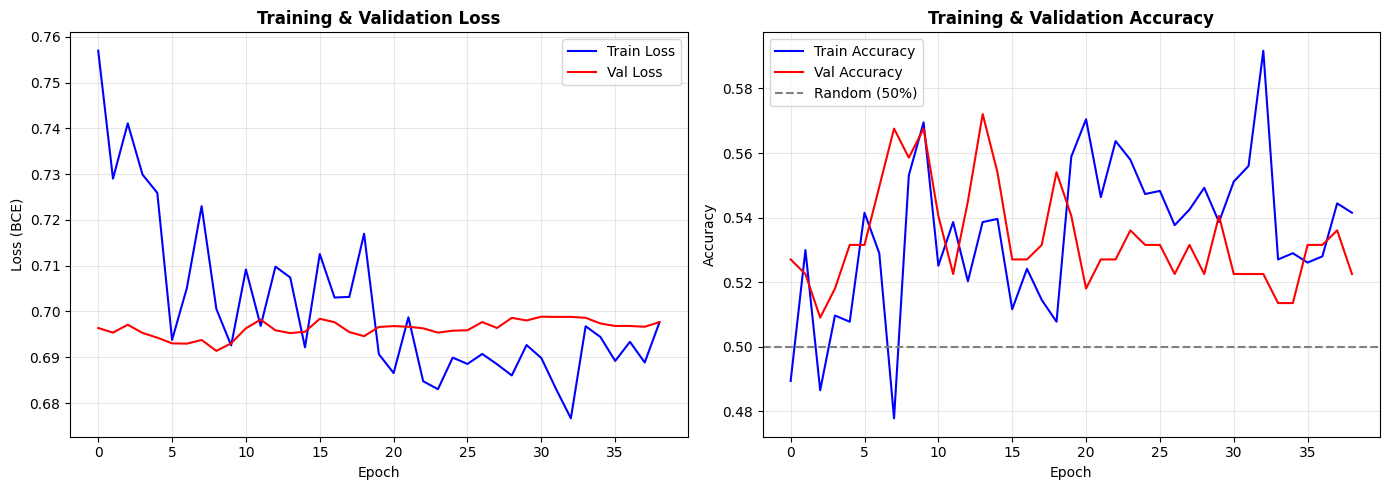

In [7]:
# Plot training history
print("TRAINING HISTORY")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (BCE)')
axes[0].set_title('Training & Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', color='blue')
axes[1].plot(history['val_acc'], label='Val Accuracy', color='red')
axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Random (50%)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Part 4: Model Evaluation

In [8]:
# Comprehensive evaluation
print("MODEL EVALUATION")
print("="*60)

def evaluate_model(model, X, y, dataset_name):
    """
    Evaluate model with trading-relevant metrics.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        probs = outputs.cpu().numpy().flatten()
        predictions = (outputs > 0.5).float().cpu().numpy().flatten()
    
    y_true = y.cpu().numpy().flatten()
    
    # Metrics
    acc = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, zero_division=0)
    recall = recall_score(y_true, predictions, zero_division=0)
    f1 = f1_score(y_true, predictions, zero_division=0)
    
    print(f"\n📊 {dataset_name} Results:")
    print(f"  Accuracy:  {acc:.4f} ({acc*100:.1f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    
    # Confusion matrix values
    tp = ((predictions == 1) & (y_true == 1)).sum()
    tn = ((predictions == 0) & (y_true == 0)).sum()
    fp = ((predictions == 1) & (y_true == 0)).sum()
    fn = ((predictions == 0) & (y_true == 1)).sum()
    
    print(f"\n  Confusion Matrix:")
    print(f"              Predicted")
    print(f"              Down   Up")
    print(f"  Actual Down  {tn:4}  {fp:4}")
    print(f"  Actual Up    {fn:4}  {tp:4}")
    
    return predictions, probs

# Evaluate on all sets
train_preds, train_probs = evaluate_model(model, X_train_t, y_train_t, "Training Set")
val_preds, val_probs = evaluate_model(model, X_val_t, y_val_t, "Validation Set")
test_preds, test_probs = evaluate_model(model, X_test_t, y_test_t, "Test Set")

MODEL EVALUATION

📊 Training Set Results:
  Accuracy:  0.5898 (59.0%)
  Precision: 0.5781
  Recall:    0.7770
  F1 Score:  0.6630

  Confusion Matrix:
              Predicted
              Down   Up
  Actual Down   193   305
  Actual Up     120   418

📊 Validation Set Results:
  Accuracy:  0.5225 (52.3%)
  Precision: 0.5379
  Recall:    0.6667
  F1 Score:  0.5954

  Confusion Matrix:
              Predicted
              Down   Up
  Actual Down    38    67
  Actual Up      39    78

📊 Test Set Results:
  Accuracy:  0.5471 (54.7%)
  Precision: 0.5649
  Recall:    0.7190
  F1 Score:  0.6327

  Confusion Matrix:
              Predicted
              Down   Up
  Actual Down    35    67
  Actual Up      34    87



TRADING SIMULATION
Strategy total return: 111.36%
Market total return:   144.13%
Strategy Sharpe ratio: 1.47
Market Sharpe ratio:   1.68


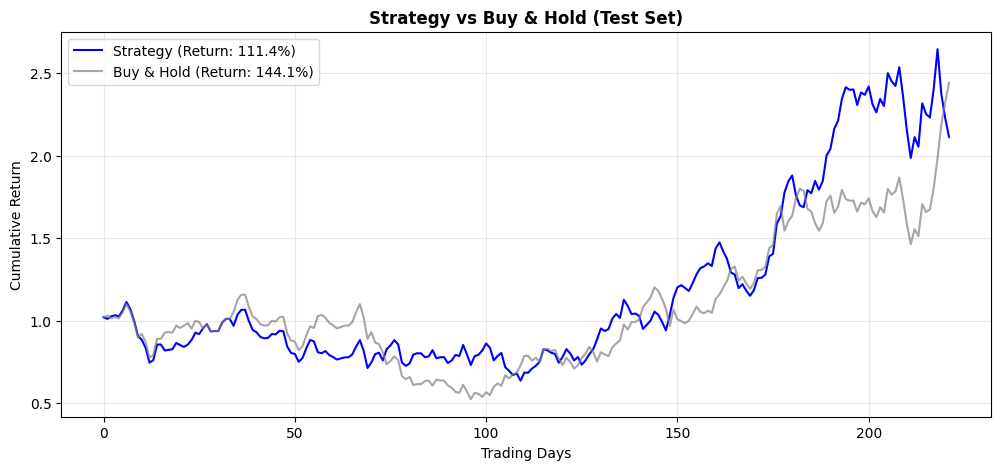

In [10]:
# Trading performance simulation
print("\nTRADING SIMULATION")
print("="*60)

# Get test returns and align with predictions
test_returns = test_df['returns'].shift(-1).dropna().values
min_len = min(len(test_returns), len(test_preds))
test_returns = test_returns[:min_len]
test_preds_aligned = test_preds[:min_len]

# Strategy returns: go long when predict up, cash when predict down
strategy_returns = test_returns * (2 * test_preds_aligned - 1)  # +1 if up, -1 if down

# Calculate metrics
cumulative_strategy = np.cumprod(1 + strategy_returns)
cumulative_market = np.cumprod(1 + test_returns)

# Trading days
trading_days = 252

# Sharpe ratio
strategy_sharpe = np.sqrt(trading_days) * strategy_returns.mean() / strategy_returns.std()
market_sharpe = np.sqrt(trading_days) * test_returns.mean() / test_returns.std()

# Total return
strategy_total = cumulative_strategy[-1] - 1
market_total = cumulative_market[-1] - 1

print(f"Strategy total return: {strategy_total*100:.2f}%")
print(f"Market total return:   {market_total*100:.2f}%")
print(f"Strategy Sharpe ratio: {strategy_sharpe:.2f}")
print(f"Market Sharpe ratio:   {market_sharpe:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(cumulative_strategy, label=f'Strategy (Return: {strategy_total*100:.1f}%)', color='blue')
plt.plot(cumulative_market, label=f'Buy & Hold (Return: {market_total*100:.1f}%)', color='gray', alpha=0.7)
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Return')
plt.title('Strategy vs Buy & Hold (Test Set)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## Part 5: Hyperparameter Tuning

In [11]:
# Simple hyperparameter search
print("HYPERPARAMETER TUNING")
print("="*60)

def train_with_config(hidden_dims, dropout_rate, lr, verbose=False):
    """Train model with specific configuration."""
    torch.manual_seed(42)
    model = TradingMLP(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout_rate=dropout_rate
    ).to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(100):
        # Train
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_val_t), y_val_t).item()
            val_acc = ((model(X_val_t) > 0.5) == y_val_t).float().mean().item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 20:
                break
    
    return best_val_loss, best_val_acc

# Grid search
configs = [
    {'hidden_dims': [32, 16], 'dropout_rate': 0.2, 'lr': 0.001},
    {'hidden_dims': [64, 32], 'dropout_rate': 0.3, 'lr': 0.001},
    {'hidden_dims': [64, 32, 16], 'dropout_rate': 0.3, 'lr': 0.001},
    {'hidden_dims': [128, 64, 32], 'dropout_rate': 0.4, 'lr': 0.0005},
]

print("Config                              | Val Loss | Val Acc")
print("-"*60)

results = []
for config in configs:
    val_loss, val_acc = train_with_config(**config)
    results.append((config, val_loss, val_acc))
    config_str = f"H={config['hidden_dims']}, D={config['dropout_rate']}, LR={config['lr']}"
    print(f"{config_str:35} | {val_loss:.4f}   | {val_acc:.4f}")

# Best config
best_config = min(results, key=lambda x: x[1])[0]
print(f"\n✅ Best config: {best_config}")

HYPERPARAMETER TUNING
Config                              | Val Loss | Val Acc
------------------------------------------------------------
H=[32, 16], D=0.2, LR=0.001         | 0.6994   | 0.5045
H=[64, 32], D=0.3, LR=0.001         | 0.6973   | 0.5676
H=[64, 32, 16], D=0.3, LR=0.001     | 0.6914   | 0.5586
H=[128, 64, 32], D=0.4, LR=0.0005   | 0.7130   | 0.4324

✅ Best config: {'hidden_dims': [64, 32, 16], 'dropout_rate': 0.3, 'lr': 0.001}


---

## Part 6: Model Saving and Loading

In [12]:
# Save and load model
print("MODEL SAVING & LOADING")
print("="*60)

# Save model state
model_path = 'trading_mlp_model.pth'

# Save complete checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'hidden_dims': [64, 32, 16],
        'dropout_rate': 0.3
    },
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'feature_names': feature_cols
}

torch.save(checkpoint, model_path)
print(f"✅ Model saved to {model_path}")

# Load model
def load_trading_model(path):
    checkpoint = torch.load(path, weights_only=False)
    config = checkpoint['model_config']
    
    model = TradingMLP(
        input_dim=config['input_dim'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint

loaded_model, loaded_checkpoint = load_trading_model(model_path)
print(f"✅ Model loaded. Features: {loaded_checkpoint['feature_names']}")

MODEL SAVING & LOADING
✅ Model saved to trading_mlp_model.pth
✅ Model loaded. Features: ['returns_lag1', 'returns_lag2', 'returns_lag3', 'returns_lag5', 'volatility_5d', 'volatility_20d', 'momentum_5d', 'momentum_20d', 'ma_ratio']


---

## 📝 Day 7 Summary

### Complete MLP Pipeline:

1. **Data Preparation**
   - Feature engineering (technical indicators)
   - Temporal train/val/test split
   - Scale features (fit on train only)

2. **Model Architecture**
   - BatchNorm for input
   - Hidden layers with ReLU + Dropout
   - Proper weight initialization

3. **Training**
   - AdamW optimizer with weight decay
   - Learning rate scheduler
   - Early stopping

4. **Evaluation**
   - Accuracy, Precision, Recall, F1
   - Confusion matrix
   - Trading simulation (Sharpe, returns)

5. **Production**
   - Save model + scaler + config
   - Load for inference

In [13]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║        DAY 7 COMPLETE: COMPLETE MLP TRADING MODEL                ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ End-to-end data pipeline                                     ║
║  ✓ Production-ready MLP architecture                            ║
║  ✓ Training with validation & early stopping                    ║
║  ✓ Comprehensive evaluation metrics                             ║
║  ✓ Trading simulation (Sharpe, returns)                         ║
║  ✓ Hyperparameter tuning                                        ║
║  ✓ Model saving and loading                                     ║
╚══════════════════════════════════════════════════════════════════╝

🎉 WEEK 9 COMPLETE! You've mastered Deep Learning fundamentals!

Next: Week 10 - Recurrent Neural Networks (LSTM, GRU)
""")


╔══════════════════════════════════════════════════════════════════╗
║        DAY 7 COMPLETE: COMPLETE MLP TRADING MODEL                ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ End-to-end data pipeline                                     ║
║  ✓ Production-ready MLP architecture                            ║
║  ✓ Training with validation & early stopping                    ║
║  ✓ Comprehensive evaluation metrics                             ║
║  ✓ Trading simulation (Sharpe, returns)                         ║
║  ✓ Hyperparameter tuning                                        ║
║  ✓ Model saving and loading                                     ║
╚══════════════════════════════════════════════════════════════════╝

🎉 WEEK 9 COMPLETE! You've mastered Deep Learning fundamentals!

Next: Week 10 - Recurrent Neural Networks (LSTM, GRU)

